In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

# Lade die Trainingsdaten
df = pd.read_csv('analysis/train_split_merged_data_updated.csv')
df['date'] = pd.to_datetime(df['date'])

# Filtere auf Warengruppe 4
df_g4 = df[df['warengruppe'] == 4].copy()

print('Datensatz Warengruppe 4:')
print(f'Zeilen: {len(df_g4)}')
print(f'\nFirst rows:')
print(df_g4[['date', 'umsatz', 'Temperatur']].head())

Datensatz Warengruppe 4:
Zeilen: 1409

First rows:
         date     umsatz  Temperatur
3  2013-07-01  65.890169     17.8375
8  2013-07-02  74.543917     17.3125
13 2013-07-03  69.262728     21.0750
18 2013-07-04  61.490175     18.8500
23 2013-07-05  86.759861     19.9750


In [13]:
# Erstelle Wochentag-Spalte
df_g4['Wochentag'] = df_g4['date'].dt.day_name()

# Übersicht über Wochentage
print('Wochentag-Verteilung:')
print(df_g4['Wochentag'].value_counts())
print('\nUmsatz nach Wochentag:')
print(df_g4.groupby('Wochentag')['umsatz'].agg(['count', 'mean', 'std']))

Wochentag-Verteilung:
Wochentag
Sunday       207
Tuesday      203
Monday       203
Thursday     202
Saturday     200
Wednesday    198
Friday       196
Name: count, dtype: int64

Umsatz nach Wochentag:
           count        mean        std
Wochentag                              
Friday       196   78.915750  24.865653
Monday       203   82.592954  28.704392
Saturday     200   85.717293  31.311293
Sunday       207  138.248851  49.927658
Thursday     202   76.955306  28.268627
Tuesday      203   77.877265  21.660964
Wednesday    198   76.278481  20.341896


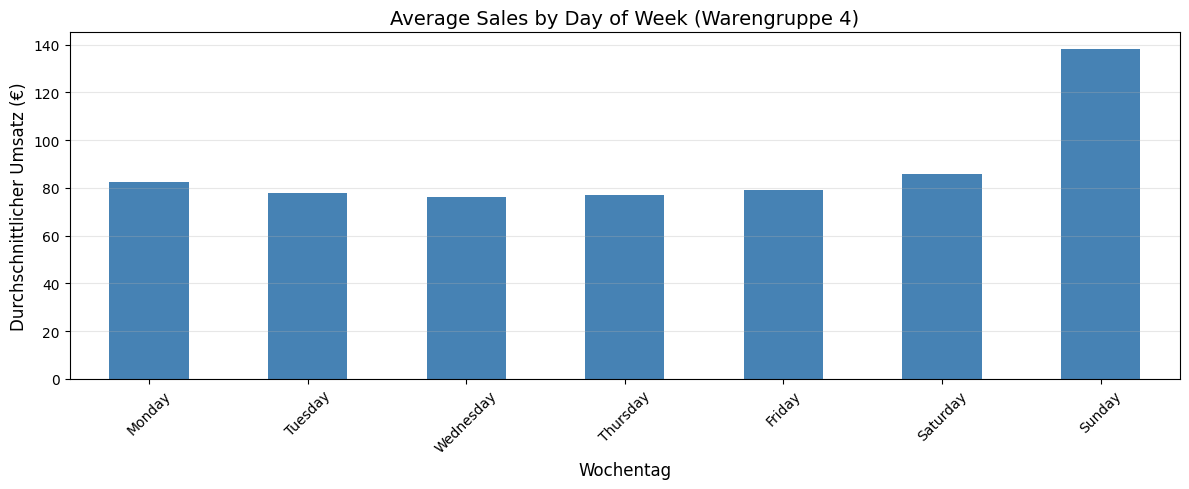

In [14]:
# Visualisiere: Umsatz nach Wochentag
plt.figure(figsize=(12, 5))
wochentage_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_g4_grouped = df_g4.groupby('Wochentag')['umsatz'].mean().reindex(wochentage_order)
df_g4_grouped.plot(kind='bar', color='steelblue')
plt.title('Average Sales by Day of Week (Warengruppe 4)', fontsize=14)
plt.xlabel('Wochentag', fontsize=12)
plt.ylabel('Durchschnittlicher Umsatz (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Vorbereite Daten: entferne NaN in Temperatur
data_clean = df_g4[['Temperatur', 'Wochentag', 'umsatz']].dropna()

print(f'Zeilen nach NaN-Entfernung: {len(data_clean)} (von {len(df_g4)})')
print(f'\nBasic stats:')
print(data_clean.describe())

# One-Hot Encoding für Wochentage (erstelle Dummy-Variablen)
# Verwende drop_first=True, um Multicollinearity zu vermeiden
wochentag_dummies = pd.get_dummies(data_clean['Wochentag'], drop_first=True, prefix='Day')

print(f'\nWochentag Dummy-Spalten:')
print(wochentag_dummies.head())

# Kombiniere Temperatur + Wochentag-Dummies
X = pd.concat([data_clean[['Temperatur']].reset_index(drop=True), 
               wochentag_dummies.reset_index(drop=True)], axis=1)
y = data_clean['umsatz'].reset_index(drop=True)

print(f'\nFinal X shape: {X.shape}')
print(f'Final y shape: {y.shape}')
print(f'\nFeature-Namen: {X.columns.tolist()}')

Zeilen nach NaN-Entfernung: 1408 (von 1409)

Basic stats:
        Temperatur       umsatz
count  1408.000000  1408.000000
mean     12.207572    88.302294
std       7.032816    37.225017
min      -8.475000    31.649727
25%       6.706250    65.441456
50%      11.875000    79.085947
75%      17.962500    97.770936
max      31.437500   430.500089

Wochentag Dummy-Spalten:
    Day_Monday  Day_Saturday  Day_Sunday  Day_Thursday  Day_Tuesday  \
3         True         False       False         False        False   
8        False         False       False         False         True   
13       False         False       False         False        False   
18       False         False       False          True        False   
23       False         False       False         False        False   

    Day_Wednesday  
3           False  
8           False  
13           True  
18          False  
23          False  

Final X shape: (1408, 7)
Final y shape: (1408,)

Feature-Namen: ['Temperatur', '

In [16]:
# Trainiere das Modell mit Temperatur + Wochentag
model = LinearRegression()
model.fit(X, y)

# Vorhersagen
y_pred = model.predict(X)

# Performance-Metriken
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print('='*70)
print('MODEL PERFORMANCE: Temperatur + Wochentag (Warengruppe 4)')
print('='*70)
print(f'R² Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}€')
print(f'MAE: {mae:.4f}€')
print(f'\nInterpretation:')
print(f'- R² = {r2:.4f}: Das Modell erklärt {r2*100:.2f}% der Varianz')
print(f'- Durchschnittlicher Fehler (MAE): ±{mae:.2f}€')

MODEL PERFORMANCE: Temperatur + Wochentag (Warengruppe 4)
R² Score: 0.3318
RMSE: 30.4190€
MAE: 20.4775€

Interpretation:
- R² = 0.3318: Das Modell erklärt 33.18% der Varianz
- Durchschnittlicher Fehler (MAE): ±20.48€


In [ ]:
y_pred

#ID, predictions --> CVS

array([ 78.83894888,  74.36860202,  70.36217158, ...,  80.97898089,
       130.76966583,  75.64274437], shape=(1408,))

In [17]:
# Zeige die Modellgleichung
print('\n' + '='*70)
print('MODELLGLEICHUNG')
print('='*70)

intercept = model.intercept_
coef_temp = model.coef_[0]
coef_wochentag = model.coef_[1:]
feature_names = ['Temperatur'] + X.columns.tolist()[1:]

print(f'\nIntercept (Basis-Umsatz): {intercept:.4f}€')
print(f'\nKoeffizient für Temperatur: {coef_temp:.4f}€ pro °C')

print(f'\nKoeffizienten für Wochentage (relativ zu {X.columns.tolist()[1:][0]}):')
for fname, coef in zip(X.columns.tolist()[1:], coef_wochentag):
    print(f'  {fname:20s}: {coef:+.4f}€')

# Volle Gleichung ausgeben
print(f'\n' + '-'*70)
print('VEREINFACHTE GLEICHUNG:')
print('-'*70)
equation = f'umsatz = {intercept:.4f} + {coef_temp:.4f}×Temperatur'
for fname, coef in zip(X.columns.tolist()[1:], coef_wochentag):
    equation += f' {coef:+.4f}×{fname}'

print(f'{equation}')


MODELLGLEICHUNG

Intercept (Basis-Umsatz): 87.0326€

Koeffizient für Temperatur: -0.6506€ pro °C

Koeffizienten für Wochentage (relativ zu Day_Monday):
  Day_Monday          : +3.4119€
  Day_Saturday        : +6.7149€
  Day_Sunday          : +59.3521€
  Day_Thursday        : -2.0855€
  Day_Tuesday         : -1.4000€
  Day_Wednesday       : -2.9585€

----------------------------------------------------------------------
VEREINFACHTE GLEICHUNG:
----------------------------------------------------------------------
umsatz = 87.0326 + -0.6506×Temperatur +3.4119×Day_Monday +6.7149×Day_Saturday +59.3521×Day_Sunday -2.0855×Day_Thursday -1.4000×Day_Tuesday -2.9585×Day_Wednesday


In [18]:
# Vergleich: nur Temperatur vs. Temperatur + Wochentag
print('\n' + '='*70)
print('VERGLEICH: NUR TEMPERATUR vs. TEMPERATUR + WOCHENTAG')
print('='*70)

# Modell nur mit Temperatur
X_temp_only = data_clean[['Temperatur']].values
model_temp_only = LinearRegression()
model_temp_only.fit(X_temp_only, y)
y_pred_temp = model_temp_only.predict(X_temp_only)
r2_temp = r2_score(y, y_pred_temp)
mae_temp = mean_absolute_error(y, y_pred_temp)

print(f'\nNur Temperatur:')
print(f'  R² = {r2_temp:.4f} ({r2_temp*100:.2f}%)')
print(f'  MAE = {mae_temp:.4f}€')

print(f'\nTemperatur + Wochentag:')
print(f'  R² = {r2:.4f} ({r2*100:.2f}%)')
print(f'  MAE = {mae:.4f}€')

improvement = ((r2 - r2_temp) / r2_temp) * 100
print(f'\n✓ Verbesserung: {improvement:+.2f}% durch Wochentag-Feature')
print(f'✓ MAE-Reduktion: {mae_temp - mae:.2f}€')


VERGLEICH: NUR TEMPERATUR vs. TEMPERATUR + WOCHENTAG

Nur Temperatur:
  R² = 0.0135 (1.35%)
  MAE = 25.6834€

Temperatur + Wochentag:
  R² = 0.3318 (33.18%)
  MAE = 20.4775€

✓ Verbesserung: +2354.38% durch Wochentag-Feature
✓ MAE-Reduktion: 5.21€


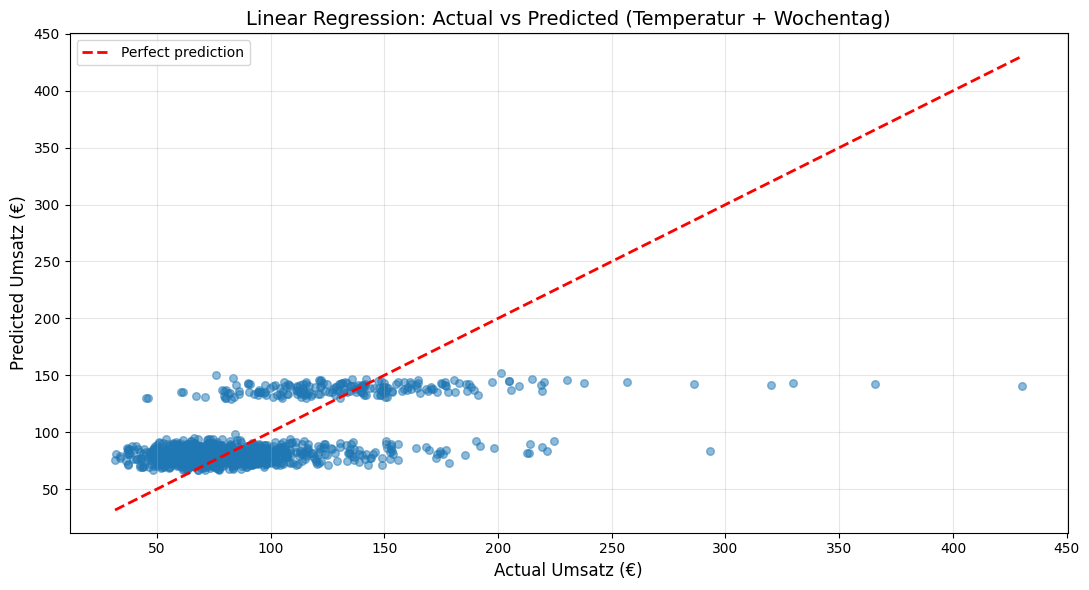

In [19]:
# Visualisierung: Actual vs Predicted
plt.figure(figsize=(11, 6))
plt.scatter(y, y_pred, alpha=0.5, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Umsatz (€)', fontsize=12)
plt.ylabel('Predicted Umsatz (€)', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted (Temperatur + Wochentag)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

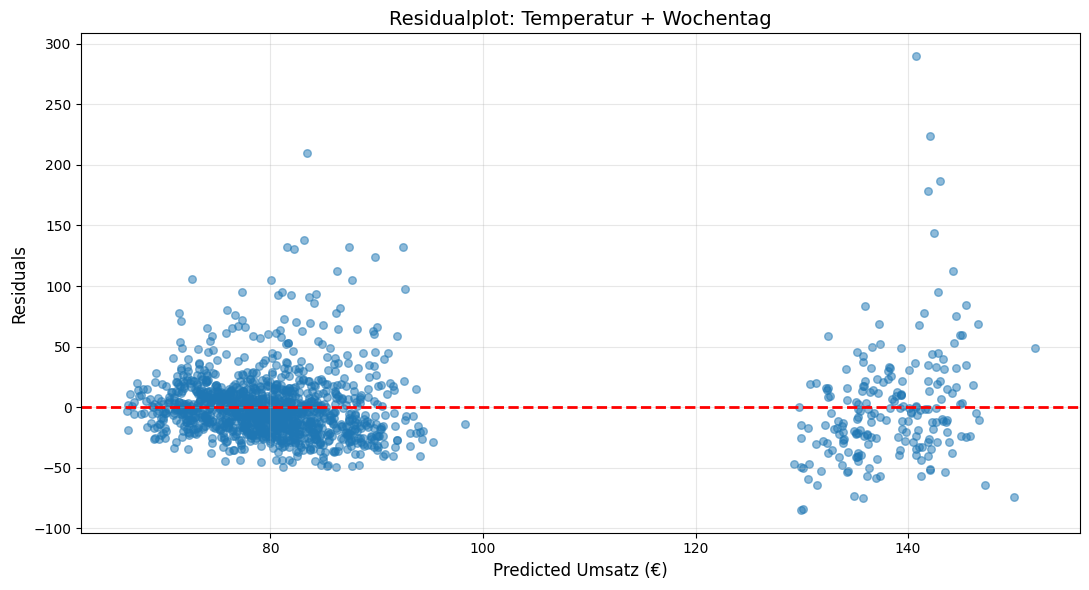

Residual Statistics:
Mean: 0.000000 (sollte nahe 0 sein)
Std: 30.429808


In [20]:
# Residualplot
residuals = y - y_pred

plt.figure(figsize=(11, 6))
plt.scatter(y_pred, residuals, alpha=0.5, s=30)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Umsatz (€)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residualplot: Temperatur + Wochentag', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Residual Statistics:')
print(f'Mean: {residuals.mean():.6f} (sollte nahe 0 sein)')
print(f'Std: {residuals.std():.6f}')

In [21]:
# Vorhersagen für verschiedene Szenarien
print('\n' + '='*70)
print('BEISPIEL-VORHERSAGEN: Verschiedene Tage + Temperaturen')
print('='*70)

wochentage_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
temperatures_list = [0, 10, 20, 30]

print('\nUmsatz-Vorhersage (€) für verschiedene Kombinationen:\n')
print('Temperatur'.ljust(15), end='')
for tag in wochentage_list:
    print(f'{tag[:3]:>8}', end='')
print()
print('-' * 75)

for temp in temperatures_list:
    print(f'{temp:>3}°C'.ljust(15), end='')
    for tag in wochentage_list:
        # Erstelle ein Feature-Vektor für diese Kombination
        feature_row = [temp]
        for col in X.columns[1:]:
            # Extrahiere den Wochentag aus dem Feature-Namen (z.B. 'Day_Monday')
            if tag in col:
                feature_row.append(1)
            else:
                feature_row.append(0)
        
        pred = model.predict([feature_row])[0]
        print(f'{pred:>8.2f}', end='')
    print()


BEISPIEL-VORHERSAGEN: Verschiedene Tage + Temperaturen

Umsatz-Vorhersage (€) für verschiedene Kombinationen:

Temperatur          Mon     Tue     Wed     Thu     Fri     Sat     Sun
---------------------------------------------------------------------------
  0°C             90.44   85.63   84.07   84.95   87.03   93.75  146.38
 10°C             83.94   79.13   77.57   78.44   80.53   87.24  139.88
 20°C             77.43   72.62   71.06   71.93   74.02   80.73  133.37
 30°C             70.93   66.11   64.56   65.43   67.51   74.23  126.87


c:\Users\Viki\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Viki\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Viki\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Viki\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Viki\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2749

In [22]:
# Effektgröße: Durchschnittlicher Umsatz pro Wochentag
print('\n' + '='*70)
print('DURCHSCHNITTLICHE UMSÄTZE PRO WOCHENTAG (Rohdaten)')
print('='*70)

wochentag_means = df_g4.groupby('Wochentag')['umsatz'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

for tag, mean in wochentag_means.items():
    print(f'{tag:12s}: {mean:7.2f}€')

# Finde Best & Worst Day
best_day = wochentag_means.idxmax()
worst_day = wochentag_means.idxmin()
diff = wochentag_means[best_day] - wochentag_means[worst_day]

print(f'\nBesser Tag: {best_day} ({wochentag_means[best_day]:.2f}€)')
print(f'Schlechtester Tag: {worst_day} ({wochentag_means[worst_day]:.2f}€)')
print(f'Differenz: {diff:.2f}€ ({(diff/wochentag_means[worst_day]*100):.1f}%)')


DURCHSCHNITTLICHE UMSÄTZE PRO WOCHENTAG (Rohdaten)
Monday      :   82.59€
Tuesday     :   77.88€
Wednesday   :   76.28€
Thursday    :   76.96€
Friday      :   78.92€
Saturday    :   85.72€
Sunday      :  138.25€

Besser Tag: Sunday (138.25€)
Schlechtester Tag: Wednesday (76.28€)
Differenz: 61.97€ (81.2%)
